Identifying common channels ...
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
P100: 117 ms, N170: 172 ms, P300: 250 ms


C:\Users\Julia\AppData\Local\Temp\ipykernel_21620\2592310111.py:95: UserWarning: The figure layout has changed to tight
  f.tight_layout()


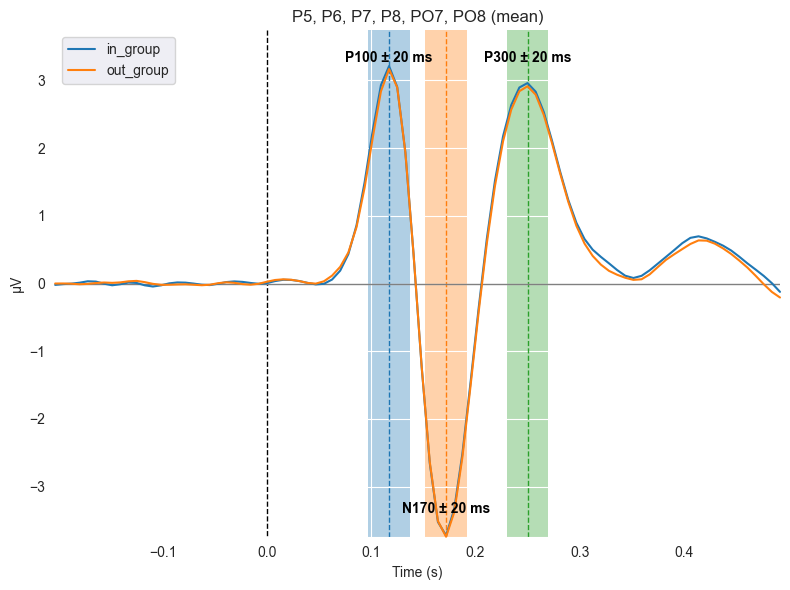

In [5]:
import os, glob
import matplotlib.pyplot as plt
import mne

data_dir = r'D:\studia\magisterka\dane EEG\BADANIE_POLITYCZNE_2022_eeg_bdfy\EEG_preprocessed'
file_pattern = os.path.join(data_dir, 's*.bdf-epo.fif')
files = sorted(glob.glob(file_pattern))

picks_of_interest = ['P5', 'P6', 'P7', 'P8', 'PO7', 'PO8']

# Evokeds per person
evokeds_in, evokeds_out = [], []
for fpath in files:
    epochs = mne.read_epochs(fpath, preload=True, verbose='ERROR')
    evokeds_in.append(epochs['in'].average())  # evokeds_in.append(epochs['inv'].average())
    evokeds_out.append(epochs['out'].average()) # evokeds_out.append(epochs['up'].average())

ga_in  = mne.grand_average(evokeds_in)
ga_out = mne.grand_average(evokeds_out)

picks_final = [ch for ch in picks_of_interest if ch in ga_in.ch_names]

evokeds_dict = dict(in_group=ga_in, out_group=ga_out) # evokeds_dict = dict(inverted=ga_in, upright=ga_out)
fig = mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=picks_final,
    combine='mean',
    ci=0.95,
    show=False,
)

sig_in  = ga_in.copy().pick(picks_final).data.mean(axis=0)
sig_out = ga_out.copy().pick(picks_final).data.mean(axis=0)
sig_ref = 0.5 * (sig_in + sig_out)
times = ga_in.times
sfreq = ga_in.info['sfreq']

def peak_time_in_window(sig, times, kind, tmin, tmax, min_dist_ms=30):
    mask = (times >= tmin) & (times <= tmax)
    if not np.any(mask):
        return np.nan
    y = sig[mask]
    distance = max(1, int((min_dist_ms/1000.0) * sfreq))
    if kind == 'pos':
        peaks, _ = find_peaks(y, distance=distance)
        idx = peaks[np.argmax(y[peaks])] if len(peaks) else np.argmax(y)
    else:
        peaks, _ = find_peaks(-y, distance=distance)
        idx = peaks[np.argmax(-y[peaks])] if len(peaks) else np.argmin(y)
    return times[mask][idx]

t_P100 = peak_time_in_window(sig_ref, times, 'pos', 0.05, 0.15)
t_N170 = peak_time_in_window(sig_ref, times, 'neg', 0.12, 0.22)
t_P300 = peak_time_in_window(sig_ref, times, 'pos', 0.20, 0.35)
print(f"P100: {t_P100*1000:.0f} ms, N170: {t_N170*1000:.0f} ms, P300: {t_P300*1000:.0f} ms")

half_win = 0.02

def shade_window(ax, t0, label=None, color='k', position='top'):
    if not np.isfinite(t0):
        return
    ax.axvspan(t0 - half_win, t0 + half_win, color=color, alpha=0.35, lw=0, zorder=0.5)
    ax.axvline(t0, color=color, ls='--', lw=1, zorder=1.5)

    if label:
        y_min, y_max = ax.get_ylim()
        text_color = 'black'
        if position == 'top':
            ax.text(t0, y_max * 0.92, label, color=text_color,
                    ha='center', va='top', fontsize=10,  fontweight='bold')
        elif position == 'bottom':
            try:
                top_z = max(getattr(ch, "get_zorder", lambda: 0)() for ch in ax.get_children()) + 10
            except ValueError:
                top_z = 10
            ax.text(t0, y_min * 0.92, label, color=text_color,
                    ha='center', va='bottom', fontsize=10,  zorder=top_z,  fontweight='bold' )

figs = fig if isinstance(fig, list) else [fig]

for f in figs:
    axes_candidates = []
    for a in f.axes:
        has_lines = len(a.lines) > 0
        has_colls = len(a.collections) > 0
        if has_lines or has_colls:
            axes_candidates.append(a)
    ax = axes_candidates[0] if axes_candidates else f.gca()

    shade_window(ax, t_P100, 'P100 ± 20 ms',  'tab:blue', position='top')
    shade_window(ax, t_N170, 'N170 ± 20 ms',  'tab:orange', position='bottom')  # <- NA DOLE
    shade_window(ax, t_P300, 'P300 ± 20 ms',  'tab:green', position='top')

    try:
        f.tight_layout()
    except Exception:
        pass

ax.axhline(0, color='gray', lw=1, zorder=3)

plt.show()


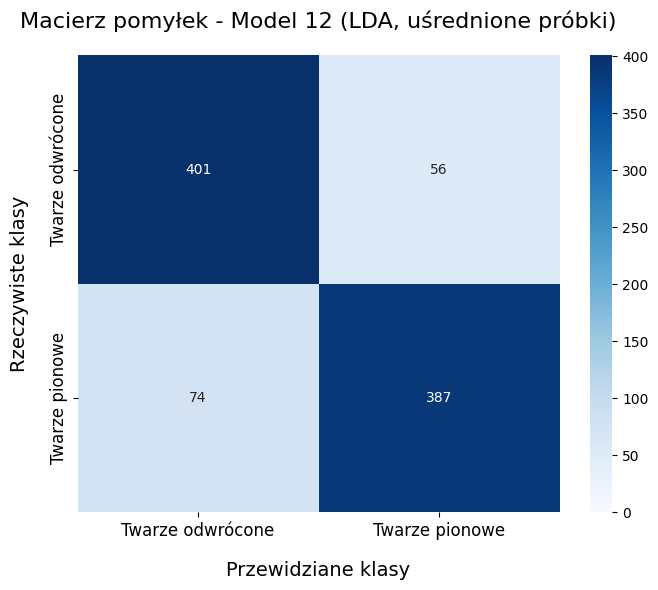

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = np.array([
    [401, 56],  # Actual odwrócone
    [74, 387]   # Actual pionowe
])

labels = ["Twarze odwrócone", "Twarze pionowe"]
pred_labels = ["Twarze odwrócone", "Twarze pionowe"]

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=pred_labels,
    yticklabels=labels,
    vmin=0,
    vmax=401
)

plt.title("Macierz pomyłek - Model 12 (LDA, uśrednione próbki)", fontsize=16, pad=20)
plt.ylabel("Rzeczywiste klasy", fontsize=14, labelpad=15)
plt.xlabel("Przewidziane klasy", fontsize=14, labelpad=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()
